In [213]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import numpy as np

# Homework 4 - Feature Descriptors

In [214]:
# helper functions

image_link_1 = "https://github.com/Avinash793/panoramic-image-stitching/blob/master/inputs/tajm4.jpg?raw=true"
image_link_2 = "https://github.com/Avinash793/panoramic-image-stitching/blob/master/inputs/tajm1.jpg?raw=true"


def download_image(image_link: str, image_name: str) -> str:
    # Download the image and save it locally as a .jpg file
    response = requests.get(image_link)
    local_filename = image_name
    with open(local_filename, "wb") as f:
        f.write(response.content)
    return local_filename

## Exercise 1

## Overview
Implement the function `exercise_1` that detects and matches SIFT features between two images.
This will allow to create a following algorithm:
1. Find keypoints and descriptors for both images
   (while you already know what keypoints are, the descriptors are some features that will allow you to match keypoints between images, feel free to read up on SIFT to get more information)
2. Use the cv.FlannBasedMatcher to find the best matches between descriptors of both images
3. Return the keypoints and the matches
4. Draw the matches on the images and display them

In [215]:
def exercise_1(img1: np.ndarray, img2: np.ndarray) -> tuple:
    """
    Detect and match SIFT features between two images.

    1. Find keypoints and descriptors for both images
    2. Use cv.FlannBasedMatcher to find the best matches
    3. Apply the ratio test (as described by David Lowe, feel free to google it, with threshold 0.6)
    4. Return the keypoints and the matches that pass the ratio test

    :param img1: First input image
    :param img2: Second input image
    :returns: Tuple containing (keypoints1, keypoints2, matches)
        Hint: look at the arguments of cv2.drawMatches to figure out how to return the matches
    """
    # <your_code_here>
    kp1, kp2, matches = None, None, None
    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    all_matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's ratio test
    matches = []
    for m, n in all_matches:
        if m.distance < 0.6 * n.distance:
            matches.append(m)
    # </your_code_here>

    return kp1, kp2, matches


<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'tuple'> <class 'tuple'>


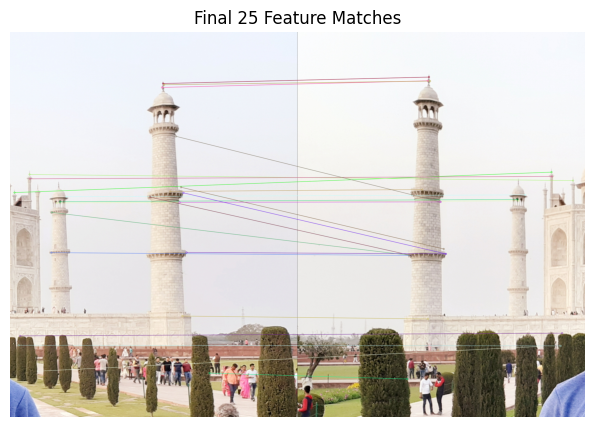

In [216]:
img1 = cv2.imread(download_image(image_link_1, "image1.jpg"))
img2 = cv2.imread(download_image(image_link_2, "image2.jpg"))
# reshape img 1 to im 2
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
# Detect and match features
kp1, kp2, final_matches = exercise_1(img1, img2)
img_matches = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    final_matches,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)


# Plot the feature matches
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title(f"Final {len(final_matches)} Feature Matches")
plt.axis("off")
plt.show()

## Exercise 2

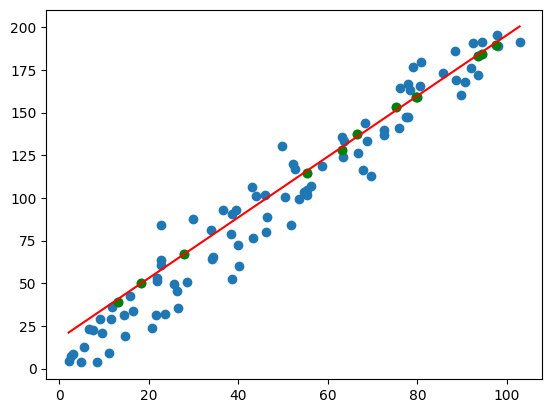

In [38]:
def exercise_2(
    points: np.ndarray,
    num_iter: int,
    threshold: float,
) -> tuple[tuple[float, float], np.ndarray]:
    """
    Implement RANSAC algorithm to fit a line to 2D points.
    1. Feel free to implement it the way you like it, just do not use cv2.RANSAC :)
    2. Setting the threshold will depend on your implementation, feel free to experiment with it
    
    :param points: Input points as Nx2 numpy array
    :param num_iter: Number of RANSAC iterations
    :param threshold: Distance threshold for inlier classification
    :returns: Tuple containing (best_model, best_inliers), where 
        - best_model is a tuple (a, b) defining the best-fit line y = ax + b
        - best_inliers is a Mx2 numpy array containing the inliers that best model has explained (M << N)
    """
    # <your_code_here>
    best_model, best_inliers = None, None
    max_inliers_count = 0
    
    for _ in range(num_iter):
        # 1. Randomly select 2 points (minimum needed for a line)
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample_points = points[sample_indices]
        
        # 2. Fit line to these points
        x1, y1 = sample_points[0]
        x2, y2 = sample_points[1]
        
        # Avoid division by zero
        if x2 - x1 == 0:
            continue
            
        # Calculate line parameters (y = ax + b)
        a = (y2 - y1) / (x2 - x1)  # slope
        b = y1 - a * x1  # intercept
        
        # 3. Calculate distances from all points to the line
        # Distance formula: |ax - y + b| / sqrt(a^2 + 1)
        distances = np.abs(a * points[:, 0] - points[:, 1] + b) / np.sqrt(a**2 + 1)
        
        # 4. Find inliers
        inlier_mask = distances < threshold
        inliers = points[inlier_mask]
        num_inliers = len(inliers)
        
        # 5. Update best model if we found more inliers
        if num_inliers > max_inliers_count:
            max_inliers_count = num_inliers
            best_inliers = inliers
            best_model = (a, b)
    # </your_code_here>

    return best_model, best_inliers

# the "secret"line that we want to fit (y = ax + b)
line = np.array([2, 1])
# create a dataset of 100 points that are sampled from the line y = ax + b
# add some noise to the points
points = np.array(
    [
        np.array([x, line[0] * x + line[1]]) + np.random.randn(2) * 5.0
        for x in range(100)
    ]
)
best_model, inliers = exercise_2(points, num_iter=10, threshold=1)

# a is the slope, b is the intercept (y = ax + b)
a, b = best_model
# inliers is a numpy array of the inliers (Nx2)
x = np.array([points[:, 0].min(), points[:, 0].max()])
y = a * x + b
plt.scatter(points[:, 0], points[:, 1])
plt.scatter(inliers[:, 0], inliers[:, 1], color="green")
plt.plot(x, y, color="red")
plt.show()